In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [2]:
amdX = pd.read_csv('amdDF-q2.csv')
amdX = amdX.loc[:, amdX.columns != 'date']
amdX = amdX.loc[:, amdX.columns != 'Unnamed: 0']
amdX = amdX.loc[:, amdX.columns != 'daychange']
amdX = amdX.loc[:, amdX.columns != 'anger']
amdX = amdX.loc[:, amdX.columns != 'disgust']
amdX = amdX.loc[:, amdX.columns != 'fear']
amdX = amdX.loc[:, amdX.columns != 'joy']
amdX = amdX.loc[:, amdX.columns != 'sadness']
amdX = amdX.loc[:, amdX.columns != 'surprise']
amdX = amdX.loc[:, amdX.columns != 'connectivity']
amdX = amdX.loc[:, amdX.columns != 'avgdeg']

amdX = amdX.head(70)
amdX

,size,edges,diameter,clustering,volume
0,280,247,7,0.003588,51802600
1,153,119,6,0.003690,34208000
2,183,137,5,0.000000,51911700
3,177,144,4,0.005624,42897200
4,174,126,7,0.004335,39816400
...,...,...,...,...,...
65,266,228,12,0.000000,41925300
66,139,111,5,0.000000,32759900
67,240,200,9,0.000000,62098800
68,256,228,7,0.000192,37767300


<Axes: >

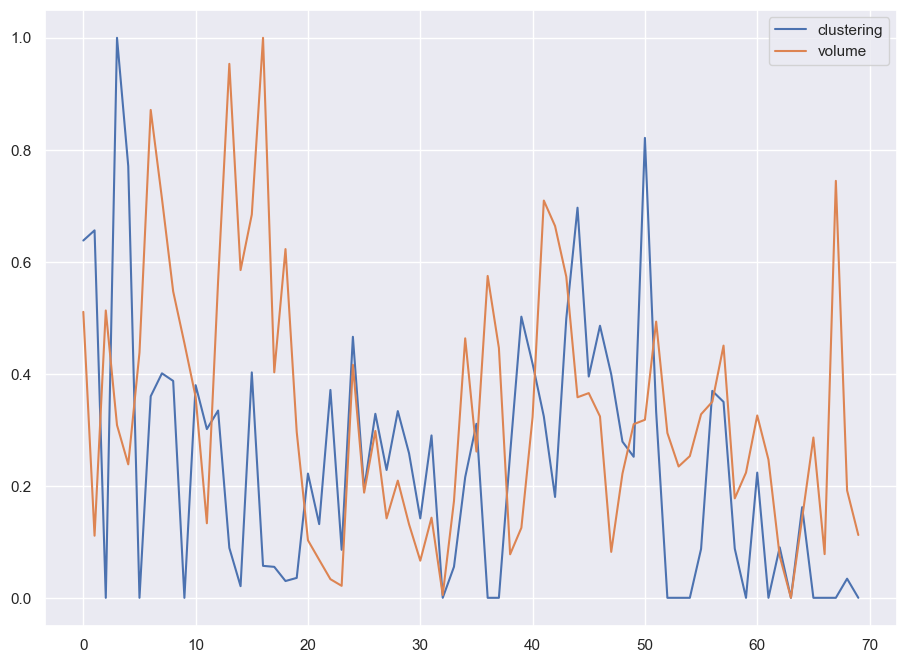

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

amdXs = scaler.fit_transform(amdX)
amdXs = pd.DataFrame(amdXs,columns=['size','edges','diameter','clustering','volume'])
amdXs[['clustering','volume']].plot()

In [4]:
for metric in amdXs.columns:
    result = adfuller(amdXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 0.008732690354535593

A-DF of metric edges has p-value of 0.007717302278131009

A-DF of metric diameter has p-value of 1.7783354800297028e-05

A-DF of metric clustering has p-value of 6.587822379399363e-08

A-DF of metric volume has p-value of 3.11224311061297e-05



In [6]:
#build the VAR model
model = VAR(amdXs)
print(model.select_order(5))

amd_model = model.fit(1)

amd_model.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Oct, 2023
Time:                     10:47:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -23.6365
Nobs:                     69.0000    HQIC:                  -24.2225
Log likelihood:           389.437    FPE:                2.06019e-11
AIC:                     -24.6078    Det(Omega_mle):     1.35783e-11
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.035123         0.034323           -1.023           0.306
L1.size               3.743968         2.267739            1.651           0.099
L1.edges             -2.998285         2.258435           -1.

Text(0, 0.5, 'Volume (0,1)')

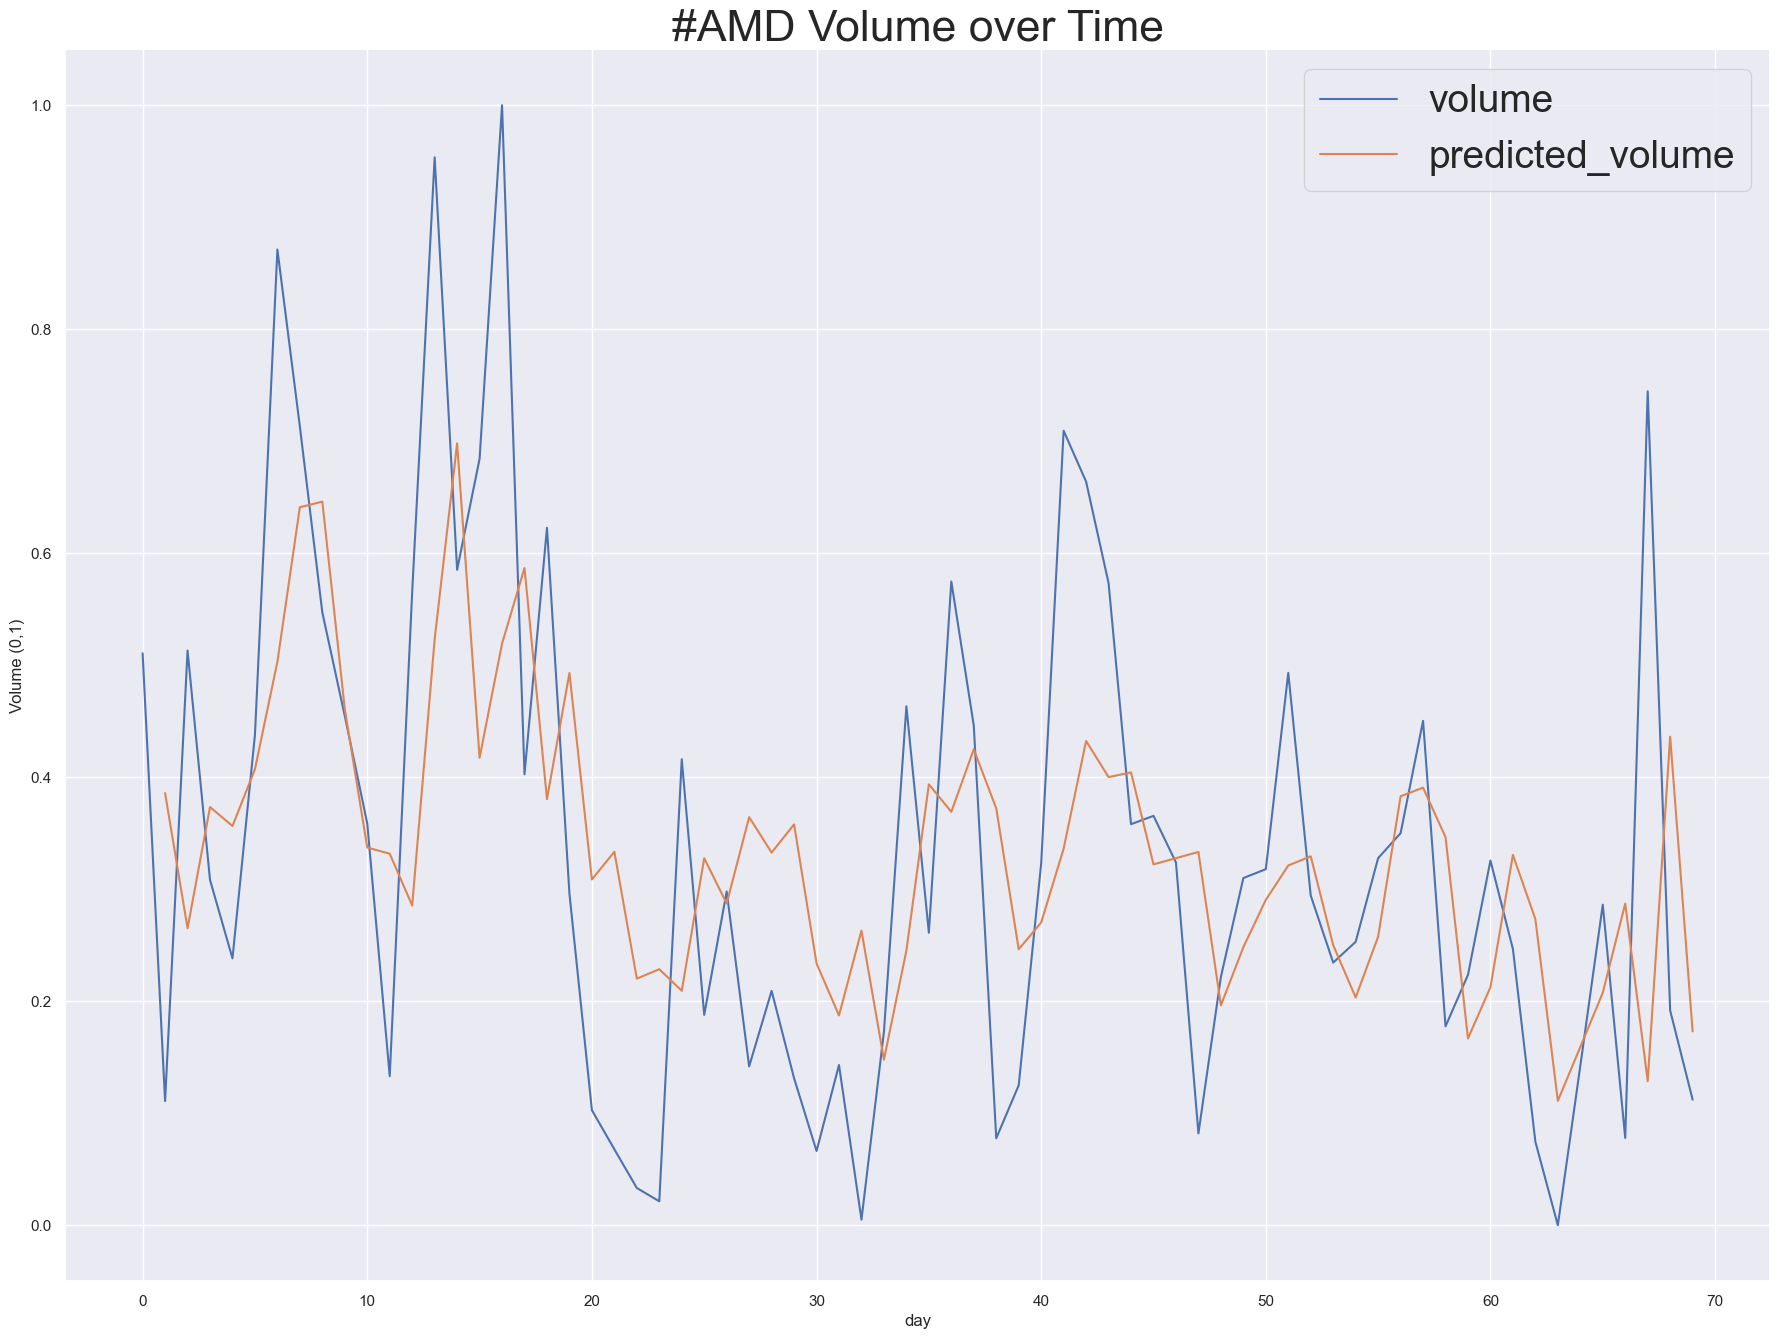

In [7]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

amdXs[['volume']].plot()
plt.plot(amd_model.fittedvalues['volume'],label='predicted_volume')
plt.legend(fontsize='28')
plt.title('#AMD Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [8]:
#test for causality
print(amd_model.test_causality(4,0))
print(amd_model.test_causality(4,1))
print(amd_model.test_causality(4,2))
print(amd_model.test_causality(4,3))
print(amd_model.test_causality(4,4))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: reject at 5% significance level. Test statistic: 4.433, critical value: 3.871>, p-value: 0.036>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: reject at 5% significance level. Test statistic: 4.406, critical value: 3.871>, p-value: 0.037>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.431, critical value: 3.871>, p-value: 0.512>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.336, critical value: 3.871>, p-value: 0.249>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: volume does not Gran

In [9]:
print('AMD',mean_absolute_error(amdXs[['volume']][1:],amd_model.fittedvalues['volume']))

AMD 0.15453726440010707
